In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
from google.colab import drive
from ortools.sat.python import cp_model

In [ ]:
!pip install ortools


In [ ]:
# Mount your Google Drive
drive.mount('/content/drive', force_remount=True)

# Paths to your files in Google Drive
# Update the paths based on the location of your files in Google Drive
census_path = '/content/drive/My Drive/240_Project/Census/ACSDT5Y2023.B01003-Data.csv'

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/My Drive/240_Project/Copy_alt_fuel_stations (Dec 12 2025)2.csv")

df_ca = df[df["State"] == "CA"]

/tmp/ipython-input-642203802.py:1: DtypeWarning: Columns (20,31,40,46,64,69,74) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/drive/My Drive/240_Project/Copy_alt_fuel_stations (Dec 12 2025)2.csv")


In [ ]:
df

,Fuel Type Code,Station Name,Street Address,Intersection Directions,City,State,ZIP,Plus4,Station Phone,Status Code,...,RD Blends,RD Blends (French),RD Blended with Biodiesel,RD Maximum Biodiesel Level,NPS Unit Name,CNG Station Sells Renewable Natural Gas,LNG Station Sells Renewable Natural Gas,Maximum Vehicle Class,EV Workplace Charging,Funding Sources
0,ELEC,Los Angeles Convention Center,1201 S Figueroa St,West hall and South hall,Los Angeles,CA,90015.0,NaN,213-741-1151,E,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LD,False,NaN
1,ELEC,Scripps Green Hospital,10666 N Torrey Pines Rd,"Patient Parking Structure, level G",La Jolla,CA,92037.0,NaN,NaN,E,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN
2,ELEC,Galpin Motors,15421 Roscoe Blvd,NaN,Sepulveda,CA,91343.0,NaN,855-889-2811,E,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MD,False,NaN
3,ELEC,Galleria at Tyler,1299 Galleria at Tyler,NaN,Riverside,CA,92503.0,NaN,951-351-3110,E,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LD,False,NaN
4,ELEC,City of Pasadena - Holly Street Garage,150 E Holly St,NaN,Pasadena,CA,91103.0,NaN,626-744-7665,E,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LD,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78342,ELEC,AKFL TEMP ACTIVATIO2,400 Pine Canyon Dr,NaN,Salt Flat,TX,79847.0,NaN,888-758-4389,E,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN
78343,ELEC,AKFL TEMP ACTIVATIO3,400 Pine Canyon Dr,NaN,Salt Flat,TX,79847.0,NaN,888-758-4389,E,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN
78344,ELEC,AKFL TEMP ACTIVATION,400 Pine Canyon Dr,NaN,Salt Flat,TX,79847.0,NaN,888-758-4389,E,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN
78345,ELEC,Simon Property Group Great Lakes Crossing (Aub...,4000 Baldwin Rd,NaN,Auburn Hills,MI,48326.0,NaN,833-632-2778,E,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN


In [ ]:
# San Francisco bounding box
lon_min, lon_max = -122.52, -122.35
lat_min, lat_max = 37.70, 37.83

df_sf = df_ca[
    (df_ca["Longitude"] >= lon_min) &
    (df_ca["Longitude"] <= lon_max) &
    (df_ca["Latitude"]  >= lat_min) &
    (df_ca["Latitude"]  <= lat_max)
]

In [ ]:
pop_csv = "/content/drive/My Drive/240_Project/Census/ACSDT5Y2023.B01003-Data.csv"
pop = pd.read_csv(pop_csv, dtype={"GEO_ID": str, "GEOID": str})

In [ ]:
if "GEOID" not in pop.columns and "GEO_ID" in pop.columns:
    pop["GEOID"] = pop["GEO_ID"].str[-11:]

In [ ]:
pop_sf = pop[pop["GEOID"].str.startswith("06075")].copy()

In [ ]:
pop_col = "B01003_001E"
if pop_col not in pop_sf.columns:
    raise ValueError(f"Population column {pop_col} not found in population CSV")

In [ ]:
tract_shp = "/content/drive/My Drive/240_Project/Census/tl_2023_06_tract/tl_2023_06_tract.shp"
tracts = gpd.read_file(tract_shp)

In [ ]:
tracts_sf = tracts[(tracts["STATEFP"] == "06") & (tracts["COUNTYFP"] == "075")].copy()

tracts_sf = tracts_sf.to_crs(epsg=3857)
tracts_sf["centroid"] = tracts_sf.geometry.centroid
tracts_sf = tracts_sf.set_geometry("centroid").to_crs(epsg=4326)

tracts_sf["lon"] = tracts_sf.geometry.x
tracts_sf["lat"] = tracts_sf.geometry.y

In [ ]:
demand = tracts_sf[["GEOID", "lon", "lat"]].merge(
    pop_sf[["GEOID", pop_col]],
    on="GEOID",
    how="inner"
)


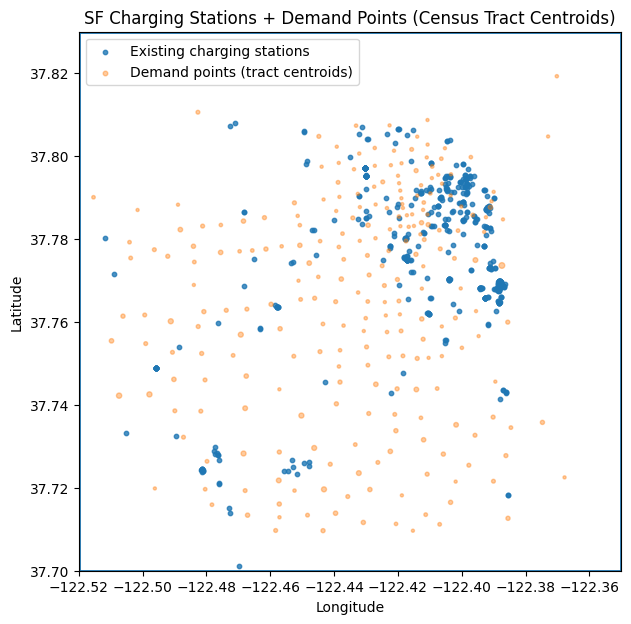

SF stations plotted: 532
SF demand points plotted: 244


In [ ]:
plt.figure(figsize=(7, 7))

plt.scatter(df_sf["Longitude"], df_sf["Latitude"], s=10, alpha=0.8, label="Existing charging stations")

sizes = (demand[pop_col].astype(float) * 0.002).clip(5, 80)
plt.scatter(demand["lon"], demand["lat"], s=sizes, alpha=0.4, label="Demand points (tract centroids)")

plt.plot([lon_min, lon_max, lon_max, lon_min, lon_min],
         [lat_min, lat_min, lat_max, lat_max, lat_min],
         linewidth=2)
plt.xlim(-122.52, -122.35)
plt.ylim(37.70, 37.83)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("SF Charging Stations + Demand Points (Census Tract Centroids)")
plt.legend()
plt.show()

print("SF stations plotted:", len(df_sf))
print("SF demand points plotted:", len(demand))

In [ ]:
def haversine_km(lon1, lat1, lon2, lat2):
    """
    lon1, lat1: scalars or arrays
    lon2, lat2: scalars or arrays
    returns: distances in km with broadcasting
    """
    R = 6371.0
    lon1 = np.radians(lon1)
    lat1 = np.radians(lat1)
    lon2 = np.radians(lon2)
    lat2 = np.radians(lat2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat / 2.0) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0) ** 2
    return 2.0 * R * np.arcsin(np.sqrt(a))


In [ ]:
def build_candidates_scheme_A(E_df, P_df, R_km=5.0, lon_col="lon", lat_col="lat"):
    """
    Returns:
      C_df: candidates (subset of P_df) that are NOT covered by any existing station within R_km
      covered_mask: boolean array for P_df indicating covered by existing
    """
    # demand arrays
    P_lon = P_df[lon_col].to_numpy(dtype=float)
    P_lat = P_df[lat_col].to_numpy(dtype=float)

    # existing arrays
    E_lon = E_df[lon_col].to_numpy(dtype=float)
    E_lat = E_df[lat_col].to_numpy(dtype=float)

    covered = np.zeros(len(P_df), dtype=bool)

    # For each existing station, mark demand points within R_km
    # (Loop over stations is fine: 532*244 is tiny)
    for i in range(len(E_df)):
        d = haversine_km(E_lon[i], E_lat[i], P_lon, P_lat)
        covered |= (d <= R_km)

    # Candidates = uncovered demand points
    C_df = P_df.loc[~covered].copy()

    return C_df, covered

In [ ]:
E_df = df_sf.rename(columns={"Longitude":"lon", "Latitude":"lat"})
P_df = demand.rename(columns={"lon":"lon", "lat":"lat"})
R_km=1.0

C_df, covered_mask = build_candidates_scheme_A(E_df, P_df, R_km=R_km, lon_col="lon", lat_col="lat")

print("R (km):", R_km)
print("Demand points |P|:", len(P_df))
print("Covered by existing:", covered_mask.sum())
print("Uncovered => candidates |C|:", len(C_df))


R (km): 1.0
Demand points |P|: 244
Covered by existing: 179
Uncovered => candidates |C|: 65


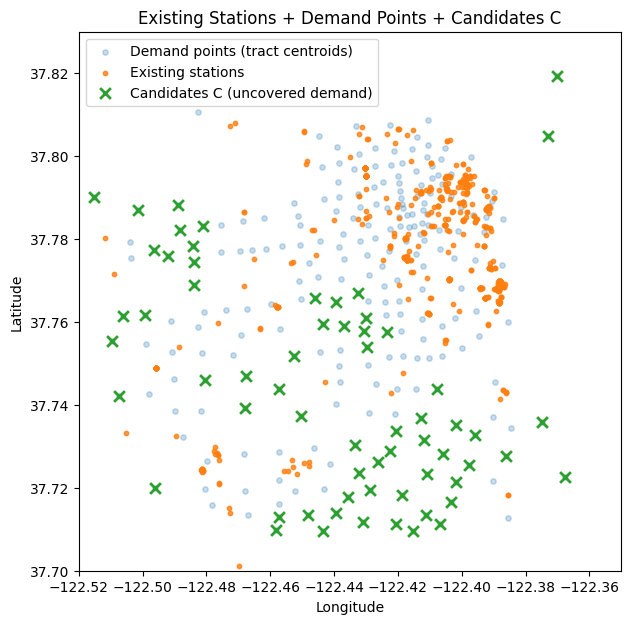

In [ ]:
lon_min, lon_max = -122.52, -122.35
lat_min, lat_max = 37.70, 37.83

plt.figure(figsize=(7, 7))

# Demand points
plt.scatter(P_df["lon"], P_df["lat"], s=15, alpha=0.25, label="Demand points (tract centroids)")

# Existing stations
plt.scatter(E_df["lon"], E_df["lat"], s=10, alpha=0.8, label="Existing stations")

# Candidate points C（
plt.scatter(C_df["lon"], C_df["lat"], s=60, marker="x", linewidths=2, label="Candidates C (uncovered demand)")

plt.xlim(lon_min, lon_max)
plt.ylim(lat_min, lat_max)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Existing Stations + Demand Points + Candidates C")
plt.legend()
plt.show()

In [ ]:
k = 5
C_df = C_df.reset_index(drop=True)

In [ ]:
def build_coverage_matrix(P_df, C_df, R_km, lon_col="lon", lat_col="lat"):
    P_lon = P_df[lon_col].to_numpy(float)
    P_lat = P_df[lat_col].to_numpy(float)
    C_lon = C_df[lon_col].to_numpy(float)
    C_lat = C_df[lat_col].to_numpy(float)

    A = np.zeros((len(P_df), len(C_df)), dtype=np.uint8)

    for j in range(len(C_df)):
        d = haversine_km(C_lon[j], C_lat[j], P_lon, P_lat)
        A[:, j] = (d <= R_km).astype(np.uint8)

    return A

A = build_coverage_matrix(P_df, C_df, R_km=R_km)
print("Coverage matrix shape:", A.shape)
print("Avg cover per candidate:", A.sum(axis=0).mean())


Coverage matrix shape: (244, 65)
Avg cover per candidate: 5.276923076923077


In [ ]:
def solve_max_coverage_ilp_aligned(A, k, weights, existing_covered_mask=None, time_limit_s=30):
    nP, nC = A.shape
    A = A.astype(np.uint8)

    existing = np.zeros(nP, dtype=bool) if existing_covered_mask is None else np.array(existing_covered_mask, dtype=bool).copy()

    w = np.array(weights, dtype=float)
    w_eff = w.copy()
    w_eff[existing] = 0.0
    w_eff = w_eff.astype(int)  # CP-SAT needs int

    model = cp_model.CpModel()
    x = [model.NewBoolVar(f"x[{j}]") for j in range(nC)]
    y = [model.NewBoolVar(f"y[{i}]") for i in range(nP)]

    model.Add(sum(x) <= int(k))

    for i in range(nP):
        coverers = [j for j in range(nC) if A[i, j] == 1]
        if not coverers:
            model.Add(y[i] == 0)
            continue

        # y <= sum(coverers)
        model.Add(y[i] <= sum(x[j] for j in coverers))
        # x[j] -> y[i]
        for j in coverers:
            model.AddImplication(x[j], y[i])

    model.Maximize(sum(int(w_eff[i]) * y[i] for i in range(nP)))

    solver = cp_model.CpSolver()
    solver.parameters.max_time_in_seconds = float(time_limit_s)
    solver.parameters.num_search_workers = 8

    status = solver.Solve(model)
    if status not in (cp_model.OPTIMAL, cp_model.FEASIBLE):
        return None

    x_sol = np.array([solver.Value(v) for v in x], dtype=int)
    selected = np.where(x_sol == 1)[0].tolist()

    if len(selected) == 0:
        sel_cov = np.zeros(nP, dtype=bool)
    else:
        sel_cov = (A[:, selected].sum(axis=1) > 0)

    final_cov = existing | sel_cov
    added_cov = sel_cov & (~existing)

    return {
        "status": status,
        "selected_indices": selected,
        "existing_covered_mask": existing,
        "final_covered_mask": final_cov,
        "added_covered_mask": added_cov,
        "existing_covered_weight": float(w[existing].sum()),
        "added_covered_weight": float(w[added_cov].sum()),
        "final_covered_weight": float(w[final_cov].sum()),
        "final_covered_count": int(final_cov.sum()),
        "added_covered_count": int(added_cov.sum()),
        "objective_added_only": float(solver.ObjectiveValue()),
    }


In [ ]:
weights = P_df["B01003_001E"].fillna(0).astype(int).to_numpy()

res_ilp = solve_max_coverage_ilp_aligned(
    A,
    k=k,
    weights=weights,
    time_limit_s=30,
    existing_covered_mask=covered_mask
)
print("ILP results")
print("Selected facilities:", len(res_ilp["selected_indices"]))
print("Existing covered population:", res_ilp["existing_covered_weight"])
print("Added covered population:", res_ilp["added_covered_weight"])
print("Final covered population:", res_ilp["final_covered_weight"])
print("Final covered demand points:", res_ilp["final_covered_count"])
print("Added covered demand points:", res_ilp["added_covered_count"])
ilp_selected = res_ilp["selected_indices"]
C_ilp = C_df.iloc[ilp_selected].copy()
C_ilp["selected"] = 1
print("ILP selected facilities:", len(ilp_selected))
display(C_ilp[["GEOID", "lon", "lat"] + (["B01003_001E"] if "B01003_001E" in C_ilp.columns else []) + ["selected"]])



ILP results
Selected facilities: 5
Existing covered population: 602871.0
Added covered population: 126365.0
Final covered population: 729236.0
Final covered demand points: 211
Added covered demand points: 32
ILP selected facilities: 5


,GEOID,lon,lat,B01003_001E,selected
2,06075025701,-122.411940,37.731583,5047,1
16,06075026003,-122.428770,37.719582,4873,1
28,06075020500,-122.437030,37.759128,2895,1
44,06075026202,-122.448318,37.713405,3664,1
58,06075042700,-122.488176,37.782271,5365,1


In [ ]:
def greedy_select_max_coverage_from_A(
    A, P_df, k,
    weight_col=None,
    existing_covered_mask=None
):
    nP, nC = A.shape
    A_bool = A.astype(bool)  # safe

    # weights
    if weight_col is None:
        w = np.ones(nP, dtype=float)
    else:
        w = P_df[weight_col].fillna(0).to_numpy(dtype=float)

    # existing covered baseline
    if existing_covered_mask is None:
        existing = np.zeros(nP, dtype=bool)
    else:
        existing = np.array(existing_covered_mask, dtype=bool).copy()

    covered = existing.copy()
    selected = []
    available = np.ones(nC, dtype=bool)

    for _ in range(int(k)):
        uncovered = ~covered

        best_j = None
        best_gain = 0.0

        for j in np.where(available)[0]:
            new_cov = A_bool[:, j] & uncovered
            gain = float(w[new_cov].sum())
            if gain > best_gain:
                best_gain = gain
                best_j = int(j)

        if best_j is None or best_gain <= 0:
            break

        selected.append(best_j)
        covered |= A_bool[:, best_j]
        available[best_j] = False

    added = covered & (~existing)

    return {
        "selected_indices": selected,
        "existing_covered_mask": existing,
        "final_covered_mask": covered,
        "added_covered_mask": added,
        "existing_covered_weight": float(w[existing].sum()),
        "added_covered_weight": float(w[added].sum()),
        "final_covered_weight": float(w[covered].sum()),
        "existing_covered_count": int(existing.sum()),
        "added_covered_count": int(added.sum()),
        "final_covered_count": int(covered.sum()),
    }


In [ ]:
A = build_coverage_matrix(P_df, C_df, R_km=R_km)

res_greedy = greedy_select_max_coverage_from_A(
    A=A,
    P_df=P_df,
    k=k,
    weight_col="B01003_001E",
    existing_covered_mask=covered_mask
)

greedy_selected = res_greedy["selected_indices"]
C_greedy = C_df.iloc[greedy_selected].copy()
C_greedy["selected"] = 1

print("=== Greedy results ===")
print("Selected facilities:", len(greedy_selected))
print("Existing covered population:", res_greedy["existing_covered_weight"])
print("Added covered population:", res_greedy["added_covered_weight"])
print("Final covered population:", res_greedy["final_covered_weight"])
print("Final covered demand points:", res_greedy["final_covered_count"])
print("Added covered demand points:", res_greedy["added_covered_count"])

C_greedy.head()


=== Greedy results ===
Selected facilities: 5
Existing covered population: 602871.0
Added covered population: 125616.0
Final covered population: 728487.0
Final covered demand points: 209
Added covered demand points: 30


,GEOID,lon,lat,B01003_001E,selected
2,06075025701,-122.411940,37.731583,5047,1
58,06075042700,-122.488176,37.782271,5365,1
27,06075026004,-122.435703,37.717892,3924,1
28,06075020500,-122.437030,37.759128,2895,1
39,06075030600,-122.457139,37.743754,2356,1


In [ ]:
k_list = list(range(1, 66))
results = []

for k in k_list:
    # ----- Greedy -----
    res_g = greedy_select_max_coverage_from_A(
        A=A,
        P_df=P_df,
        k=k,
        weight_col="B01003_001E",
        existing_covered_mask=covered_mask
    )

    # ----- ILP -----
    res_i = solve_max_coverage_ilp_aligned(
        A=A,
        k=k,
        weights=weights.astype(int),
        existing_covered_mask=covered_mask,
        time_limit_s=30
    )

    results.append({
        "k": k,
        "method": "Greedy",
        "added_pop": res_g["added_covered_weight"],
        "added_pts": res_g["added_covered_count"]
    })
    results.append({
        "k": k,
        "method": "ILP",
        "added_pop": res_i["added_covered_weight"],
        "added_pts": res_i["added_covered_count"]
    })


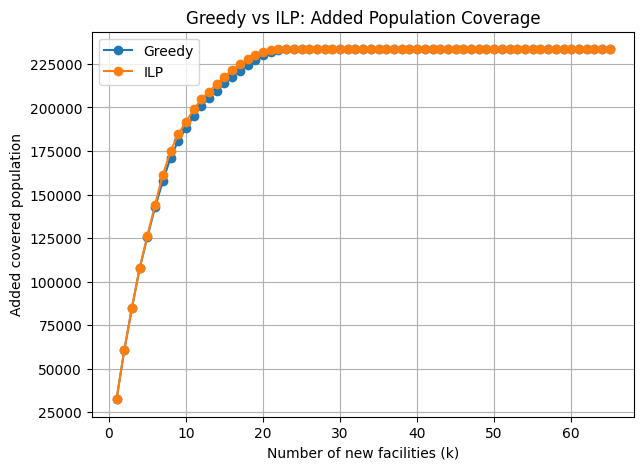

In [ ]:
df_res = pd.DataFrame(results)
plt.figure(figsize=(7,5))
for m in ["Greedy", "ILP"]:
    sub = df_res[df_res["method"] == m]
    plt.plot(sub["k"], sub["added_pop"], marker="o", label=m)

plt.xlabel("Number of new facilities (k)")
plt.ylabel("Added covered population")
plt.title("Greedy vs ILP: Added Population Coverage")
plt.legend()
plt.grid(True)
plt.show()


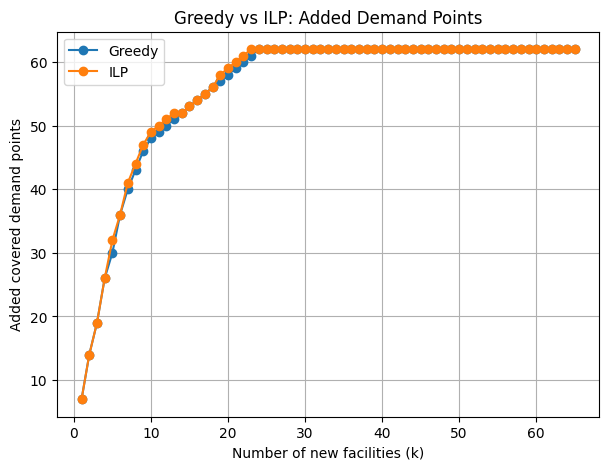

In [ ]:
plt.figure(figsize=(7,5))
for m in ["Greedy", "ILP"]:
    sub = df_res[df_res["method"] == m]
    plt.plot(sub["k"], sub["added_pts"], marker="o", label=m)

plt.xlabel("Number of new facilities (k)")
plt.ylabel("Added covered demand points")
plt.title("Greedy vs ILP: Added Demand Points")
plt.legend()
plt.grid(True)
plt.show()
